(((None, ([], [], [], 0.2, 0.2, 0.6)), (None, ([], [], [], 0.8, 0.2, 0.6)), (None, ([3], [0.44103950109485635], [0.6070082251116449], 0.2, 0.8, 0.6)), (((None, ([2], [0.6353963014802955], [0.51635678325087], 0.65, 0.65, 0.3)), (None, ([1], [0.9195756025985474], [0.7591213622681808], 0.9500000000000001, 0.65, 0.3)), (None, ([0], [0.788424839066558], [0.9018212566587508], 0.65, 0.9500000000000001, 0.3)), (None, ([], [], [], 0.9500000000000001, 0.9500000000000001, 0.3))), ([0, 1, 2], [0.788424839066558, 0.9195756025985474, 0.6353963014802955], [0.9018212566587508, 0.7591213622681808, 0.51635678325087], 0.8, 0.8, 0.6))), (Array([ 4.        +0.j        ,  0.7844363 +0.7843076j ,
        0.0407186 +0.44104326j, -0.12217202+0.15564051j,
       -0.08281118+0.01143494j], dtype=complex64), array([0, 1, 2, 3]), array([0.78842484, 0.9195756 , 0.6353963 , 0.4410395 ]), array([0.90182126, 0.75912136, 0.51635678, 0.60700823]), 0.5, 0.5, 1.2))


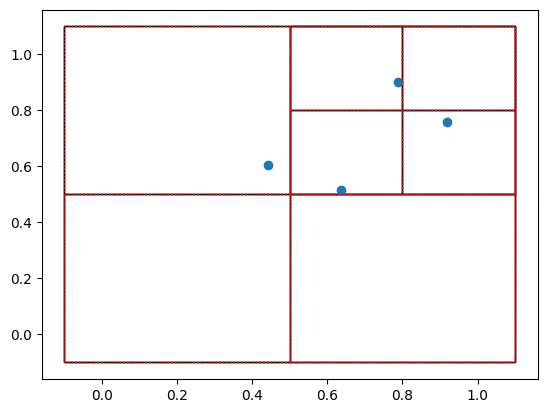

In [7]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import random, vmap, grad, jit
from jax import lax
import matplotlib.pyplot as plt

def assign_to_box(x, y, center_x, center_y):
    in_x = int(x > center_x)
    in_y = int(y > center_y)
    return in_x + 2*in_y

def split_points(i_list, x_list, y_list, center_x, center_y, width):
    boxes_i = [[], [], [], []]
    boxes_x = [[], [], [], []]
    boxes_y = [[], [], [], []]
    for i, x, y in zip(i_list, x_list, y_list):
        idx = assign_to_box(x, y, center_x, center_y)
        boxes_i[idx].append(i)
        boxes_x[idx].append(x)
        boxes_y[idx].append(y)
    return boxes_i, boxes_x, boxes_y

def get_pytree(point_ids, points_x, points_y, center_x, center_y, width, max_points=1):
    if (len(points_x) <= max_points):
        return ((None), (point_ids, points_x, points_y, center_x, center_y, width))
    else:
        boxes_i, boxes_x, boxes_y = split_points(point_ids, points_x, points_y, center_x, center_y, width)
        center_x_list = tuple(center_x + p*width/4 for p in [-1, 1, -1, 1])
        center_y_list = tuple(center_y + p*width/4 for p in [-1, -1, 1, 1])
        widths = tuple(width/2 for _ in range(4))
        children = tuple(get_pytree(i, x, y, cx, cy, w) for i, x, y, cx, cy, w \
            in zip(boxes_i, boxes_x, boxes_y, center_x_list, center_y_list, widths))
        return (children, (point_ids, points_x, points_y, center_x, center_y, width))

def plot_pytree(pytree, **kwargs):
    cx = pytree[1][-3]
    cy = pytree[1][-2]
    w = pytree[1][-1]
    rect = plt.Rectangle((cx-w/2, cy-w/2), w, w, fill=False, **kwargs)
    plt.gca().add_patch(rect)
    children = pytree[0]
    if children is not None:
        for child in children:
            plot_pytree(child, **kwargs)

def get_coef(id, x, y, cx, cy, mu):
    z = (jnp.array(x)-cx) + 1j*(jnp.array(y)-cy)
    return jnp.array([jnp.sum(mu[id]* z**n) for n in range(5)])


def identity_map(node):
    return node

def compute_coef(node, mu):
    children, (i, x, y, cx, cy, w) = node
    if len(x) == 0:
        return (children, (None, [], [], [], cx, cy, w))
    else:
        c = get_coef(i, x, y, cx, cy, mu)
        #print(c, end="\n")
        return (children, (c, i, x, y, cx, cy, w))

def is_leaf(node):
    correct_length = len(node) == 2
    correct_sub_length = len(node[1]) == 6
    return correct_length and correct_sub_length
 


N = 4
i = np.arange(N)
x = np.random.rand(N)
#y = np.sin(x) + 0.2 * np.random.rand(N)
y = np.random.rand(N)
center_x = 0.5
center_y = 0.5
width = 1.2
mu = np.ones(N)

tree = get_pytree(i, x, y, center_x, center_y, width, max_points=1)
#print(tree)
plot_pytree(tree)
plt.scatter(x, y)




new_tree = jax.tree_map(lambda *args: compute_coef(*args, mu), tree, is_leaf=is_leaf)
print(new_tree)
plot_pytree(tree, color='red', linestyle=':')

    